# "Conventional" Models

Building conventional time-series, panel & ML-models to use as starting point and benchmarks.

1. ARIMA (country-wise, tuned)
2. Lasso-Regression ("pseudo" fixed-effects (we don't prevent regularization from reducing unit-dummy coefficients to zero), tuned hyperparameter)
3. XGBoost (tuned hyperparameters)

For all models, we collect the same metrics (MSE, RMSE, MAE & $R^2$), and visually inspect (1) how predictions fare up against actual values for the test set, (2) what the models forward-predictions for the test and validation sets look like compared to the actual time series.

In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pmdarima as pm
import warnings

from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV

from statsmodels.tsa.arima.model import ARIMA

from functools import reduce

In [2]:
data = pd.read_csv("../data/final/preprocessed_full.csv", index_col=[0])
target = "net_migration_tp1"
features = data.drop(["iso3", "year", "set", target], axis=1).columns.tolist()
data = data[data["year"] < 2021]

We will use this function to collect all metrics of interest on all models:

In [3]:
def collect_metrics(y: np.array, y_hat: np.array) -> dict:
    metrics = {
        "MSE": mean_squared_error(y, y_hat),
        "RMSE": np.sqrt(mean_squared_error(y, y_hat)),
        "MAE": mean_absolute_error(y, y_hat),
        "R-squared": r2_score(y, y_hat)
    }

    return metrics

Using the same predefined non-random train-test-split layed out in preprocessing for all models:

In [33]:
train = data[data["set"] == "train"]
val = data[data["set"] == "val"]
test = data[data["set"] == "test"]

X_train, y_train = train[features], train[target]
X_val, y_val = val[features], val[target]
X_test, y_test = test[features], test[target]

## ARIMA

Treating observations for each country as separate time-series; fitting country-wise ARIMAs. We also tune the order automatically:

In [45]:
def country_wise_arima(train: pd.DataFrame, val: pd.DataFrame, test: pd.DataFrame, country: str) -> pd.DataFrame:
    prepped = train[train["iso3"] == country][["year", "net_migration"]].assign(year=lambda df: df["year"].astype(int)).set_index("year")
    prepped.index = pd.to_datetime(prepped.index, format="%Y")
    prepped.index.freq = "AS" # AS = annual start

    # Finding best order:
    auto_model = pm.auto_arima(prepped["net_migration"], seasonal=False, stepwise=True, suppress_warnings=True)

    # Fitting the best model & collecting predictions:
    model = ARIMA(prepped["net_migration"], order=auto_model.order)
    results = model.fit()

    preds = (
        pd.DataFrame(results.forecast(steps=5))
        .reset_index()
        .rename(columns={"index": "year"})
        .assign(
            year=lambda df: [date.year for date in df["year"]], 
            iso3=country
        )
    )

    out = pd.concat([
        val[val["iso3"] == country][["iso3", "year", "net_migration"]],
        test[test["iso3"] == country][["iso3", "year", "net_migration"]]
    ]).reset_index(drop=True).merge(preds, how="left", on=["iso3", "year"])

    return out

Running the ARIMAs (MLE convergence warnings for some countries can be ignored):

In [61]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    arima_list = list(map(lambda country: country_wise_arima(train, val, test, country=country), data["iso3"].unique()))

Bringing into `DataFrame`-format:

In [70]:
arima_results = reduce(lambda l, r: pd.concat([l, r]), arima_list).rename(columns={"net_migration": "actual", "predicted_mean": "predicted"})

In [80]:
# Results for test set only:
arima_results_test = arima_results[arima_results["year"].isin([2019, 2020])]
y_hat_test_arima = arima_results_test["predicted"].tolist()

Evaluating the model:

In [78]:
collect_metrics(y=arima_results_test["actual"], y_hat=arima_results_test["predicted"])

{'MSE': 0.001307239182851604,
 'RMSE': 0.03615576278896082,
 'MAE': 0.011438966239015778,
 'R-squared': -0.03366176694457623}

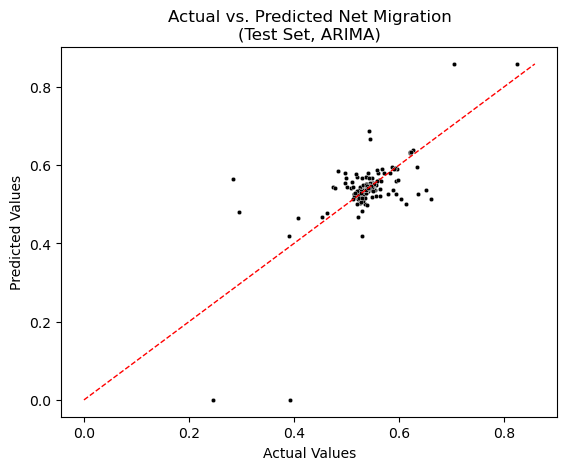

In [82]:
sns.scatterplot(x=arima_results_test["actual"], y=arima_results_test["predicted"], color="black", s=10)
min_val = min(min(arima_results_test["actual"]), min(arima_results_test["predicted"]))
max_val = max(max(arima_results_test["actual"]), max(arima_results_test["predicted"]))
plt.plot([min_val, max_val], [min_val, max_val], "r--", linewidth=1)

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Net Migration\n(Test Set, ARIMA)")
plt.show()

For comparing the predicted values to the actual time series, we cut off at 2000 to make the plot a bit less cluttered:

Text(0.5, 1.0, 'Model predictions\nARIMA, USA')

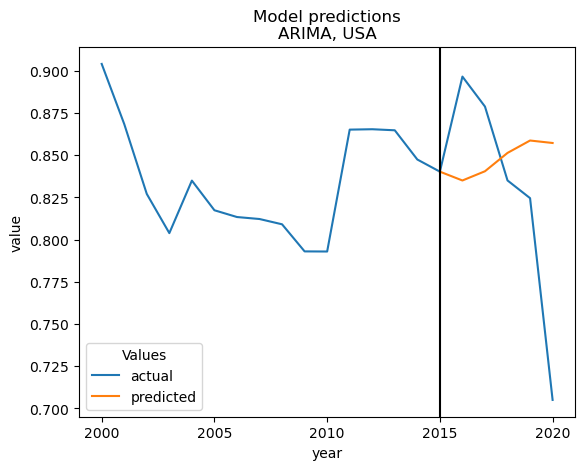

In [138]:
usa_arima = pd.concat([
    train[train["iso3"] == "USA"][["iso3", "year", "net_migration"]].reset_index(drop=True).rename(columns={"net_migration": "actual"}),
    arima_results[arima_results["iso3"] == "USA"]
])

# Set last value of train set as start:
usa_arima.loc[usa_arima["year"] == train["year"].max(), "predicted"] = usa_arima[usa_arima["year"] == train["year"].max()]["actual"].values[0]
usa_arima = usa_arima.melt(id_vars=["iso3", "year"], value_vars=["actual", "predicted"], var_name="Values")

sns.lineplot(
    data=usa_arima[usa_arima["year"] >= 2000],
    x="year",
    y="value",
    hue="Values"
)
plt.xticks(np.arange(2000, test["year"].max()+1, 5.0))
plt.axvline(x=train["year"].max(), color="black")
plt.title("Model predictions\nARIMA, USA")

Text(0.5, 1.0, 'Model predictions\nARIMA, DEU')

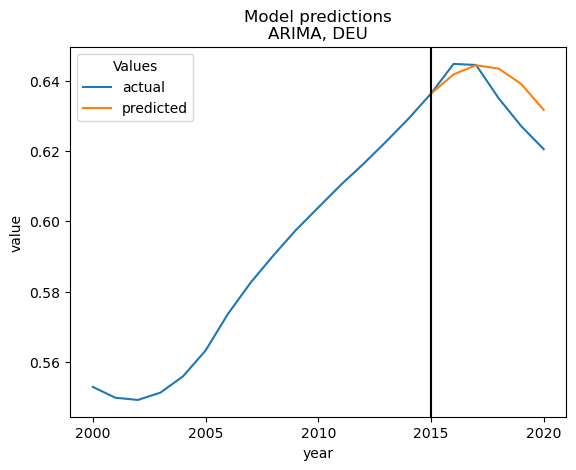

In [136]:
deu_arima = pd.concat([
    train[train["iso3"] == "DEU"][["iso3", "year", "net_migration"]].reset_index(drop=True).rename(columns={"net_migration": "actual"}),
    arima_results[arima_results["iso3"] == "DEU"]
])
deu_arima.loc[deu_arima["year"] == train["year"].max(), "predicted"] = deu_arima[deu_arima["year"] == train["year"].max()]["actual"].values[0]
deu_arima = deu_arima.melt(id_vars=["iso3", "year"], value_vars=["actual", "predicted"], var_name="Values")

sns.lineplot(
    data=deu_arima[deu_arima["year"] >= 2000],
    x="year",
    y="value",
    hue="Values"
)
plt.axvline(x=train["year"].max(), color="black")
plt.xticks(np.arange(2000, test["year"].max()+1, 5.0))
plt.title("Model predictions\nARIMA, DEU")

## Lasso-Regression

Lasso-regression with lagged dependent variable, country dummies & decade dummies (pseudo-"two-way fixed-effects"; we don't prevent regularization from reducing fixed-effects to zero):

In [139]:
lasso = Lasso()
lasso_params = {"alpha": np.arange(1e-6, 1e-4, 1e-6)}
#^ while the upper bound for alpha is technically Inf, we saw in testing that the penalty needs to be extremely small.
lasso_search = GridSearchCV(lasso, lasso_params, cv=5, scoring="neg_mean_squared_error", verbose=1, n_jobs=-1)
lasso_search.fit(X_train, y_train)
print("Best Alpha:", lasso_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Alpha: {'alpha': 4.9999999999999996e-06}


In [140]:
lasso_best = lasso_search.best_estimator_
y_hat_test_lasso = lasso_best.predict(X_test)

collect_metrics(y_test, y_hat_test_lasso)

{'MSE': 0.00045860848316275655,
 'RMSE': 0.02141514611583952,
 'MAE': 0.007401227380006136,
 'R-squared': 0.3224854407288895}

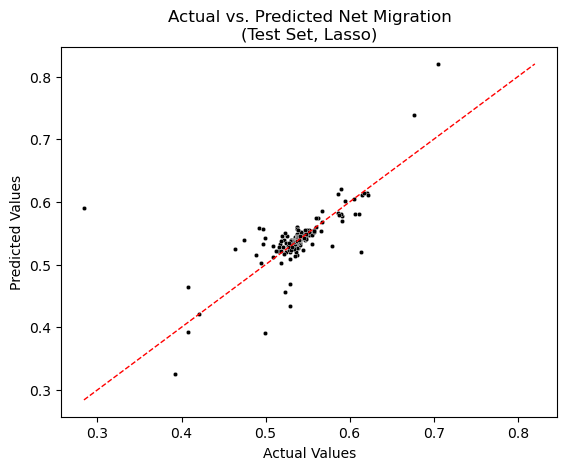

In [141]:
y_hat_test_lasso = lasso_best.predict(X_test)
sns.scatterplot(x=y_test, y=y_hat_test_lasso, color="black", s=10)
min_val = min(min(y_test), min(y_hat_test_lasso))
max_val = max(max(y_test), max(y_hat_test_lasso))
plt.plot([min_val, max_val], [min_val, max_val], "r--", linewidth=1)

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Net Migration\n(Test Set, Lasso)")
plt.show()

Most important features (by absolute coefficient):

In [142]:
coefs = pd.DataFrame({
    "feature": X_train.columns,
    "abs_coef": abs(lasso_best.coef_)
})

coefs.sort_values("abs_coef", ascending=False)[:10]

,feature,abs_coef
0,net_migration,0.651165
7,pop_growth,0.122486
213,USA,0.090119
28,BGD,0.029233
46,CHN,0.025557
160,PAK,0.021176
135,MEX,0.020929
16,ARE,0.016815
177,SAU,0.013956
60,DEU,0.013278


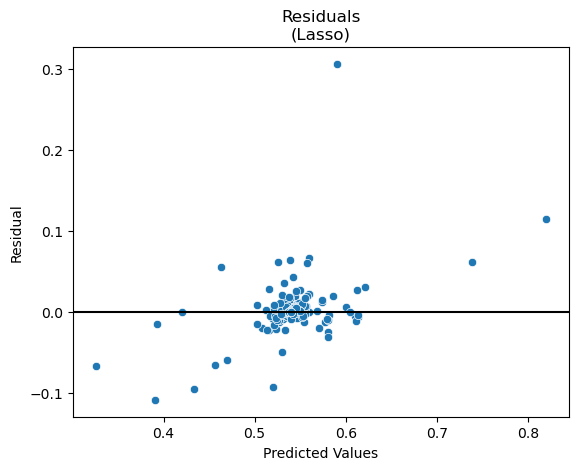

In [143]:
error_lasso = y_hat_test_lasso - y_test
sns.scatterplot(x=y_hat_test_lasso, y=error_lasso)
plt.axhline(y=0, color="black")
plt.xlabel('Predicted Values')
plt.ylabel('Residual')
plt.title('Residuals\n(Lasso)')
plt.show()

Forward prediction of validation & test set:

In [150]:
def get_forward_pred(model, country: str) -> pd.DataFrame:
    df = data[(data["iso3"] == country) & (data["year"] >= 2000)][["year", "net_migration"]].rename(columns={"net_migration": "actual"})
    predictions = pd.DataFrame({
        "year": [2016, 2017, 2018, 2019, 2020],
        "predicted": [*model.predict(X_val[X_val[country] == 1]), *model.predict(X_test[X_test[country] == 1])]
    })

    df = df.merge(predictions, how="left", on="year")
    # Set last train year value equal to show timeline:
    df.loc[df["year"] == train["year"].max(), "predicted"] = df[df["year"] == train["year"].max()]["actual"].values[0]

    return df.melt(id_vars="year", value_vars=["actual", "predicted"], value_name="value", var_name="Values")



Text(0.5, 1.0, 'Model predictions\nLasso, USA')

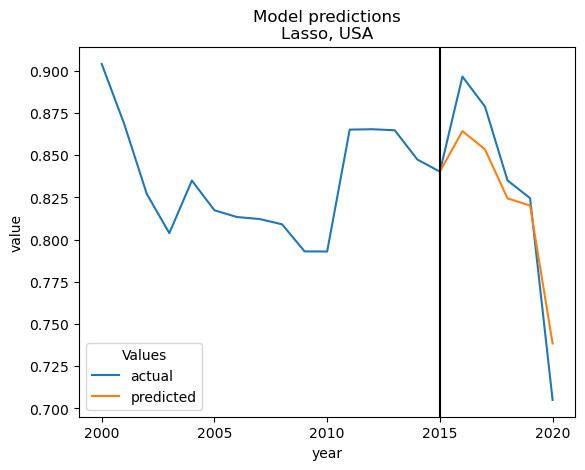

In [151]:
sns.lineplot(
    data=get_forward_pred(lasso_best, "USA"),
    x="year",
    y="value",
    hue="Values"
)
plt.axvline(x=train["year"].max(), color="black")
plt.xticks(np.arange(2000, test["year"].max()+1, 5.0))
plt.title("Model predictions\nLasso, USA")

Text(0.5, 1.0, 'Model predictions\nLasso, DEU')

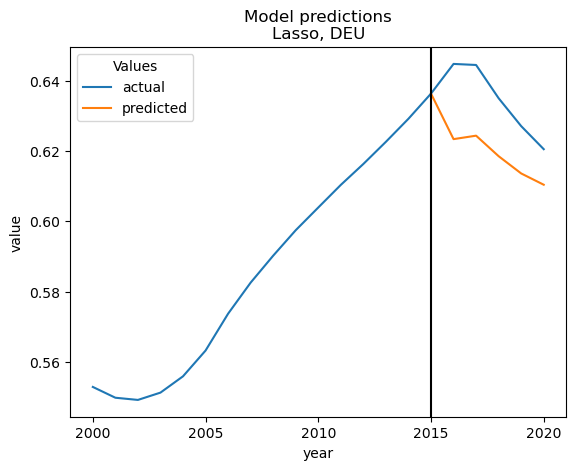

In [152]:
sns.lineplot(
    data=get_forward_pred(lasso_best, "DEU"),
    x="year",
    y="value",
    hue="Values"
)
plt.axvline(x=train["year"].max(), color="black")
plt.xticks(np.arange(2000, test["year"].max()+1, 5.0))
plt.title("Model predictions\nLasso, DEU")

## XGBoost-Regressor

In [153]:
xgb = XGBRegressor(objective="reg:squarederror", random_state=42)

param_grid = {
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [100, 300],
    "max_depth": [3, 5],
    "min_child_weight": [1, 5],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "gamma": [0, 0.1]
}

grid_search = GridSearchCV(
    estimator=xgb, 
    param_grid=param_grid, 
    cv=3,  # reduced folds bc of more hyperparams (-> bigger grid)
    scoring="neg_mean_squared_error",
    verbose=1, 
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 3 folds for each of 192 candidates, totalling 576 fits
Best Hyperparameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}


In [154]:
xgb_best = grid_search.best_estimator_
y_hat_test_xgb = xgb_best.predict(X_test)

In [155]:
collect_metrics(y_test, y_hat_test_xgb)

{'MSE': 0.0006520058770705872,
 'RMSE': 0.025534405751271895,
 'MAE': 0.00795564817135173,
 'R-squared': 0.03677430605032783}

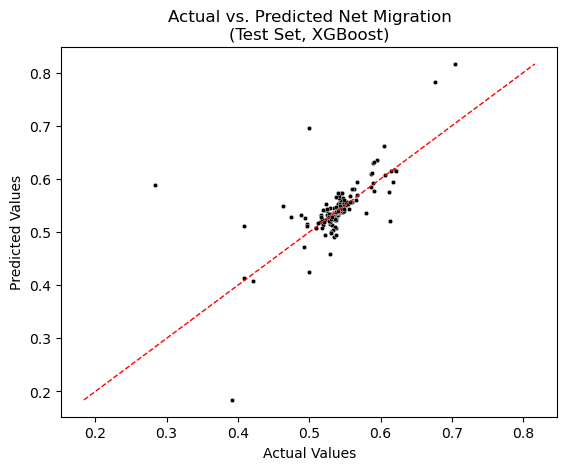

In [156]:
sns.scatterplot(x=y_test, y=y_hat_test_xgb, color="black", s=10)
min_val = min(min(y_test), min(y_hat_test_xgb))
max_val = max(max(y_test), max(y_hat_test_xgb))
plt.plot([min_val, max_val], [min_val, max_val], "r--", linewidth=1)

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Net Migration\n(Test Set, XGBoost)")
plt.show()

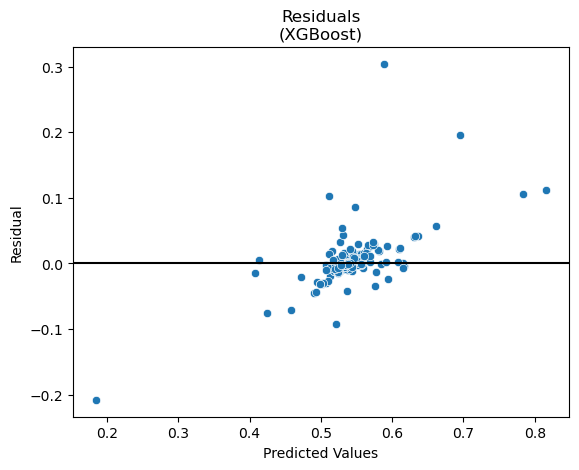

In [157]:
error_xgb = y_hat_test_xgb - y_test
sns.scatterplot(x=y_hat_test_xgb, y=error_xgb)
plt.axhline(y=0, color="black")
plt.xlabel('Predicted Values')
plt.ylabel('Residual')
plt.title('Residuals\n(XGBoost)')
plt.show()

Text(0.5, 1.0, 'Top 10 most important features\n(XGBoost)')

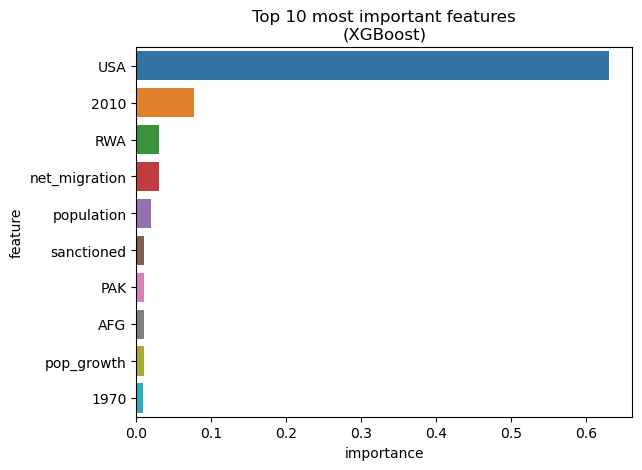

In [158]:
feature_imp = pd.DataFrame({"feature": features, "importance": xgb_best.feature_importances_})
top10_feats = feature_imp.sort_values("importance", ascending=False)[:10]

sns.barplot(
    data=top10_feats,
    x="importance",
    y="feature"
)
plt.title("Top 10 most important features\n(XGBoost)")

# net_migration = net migration in t-1

Text(0.5, 1.0, 'Model predictions\nUSA, XGBoost')

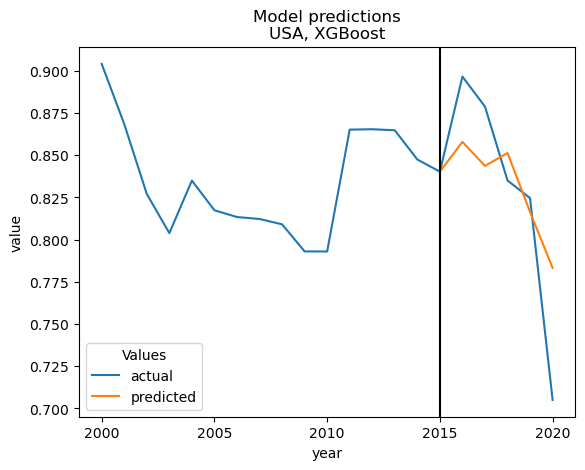

In [160]:
sns.lineplot(
    data=get_forward_pred(xgb_best, "USA"),
    x="year",
    y="value",
    hue="Values"
)
plt.axvline(x=train["year"].max(), color="black")
plt.xticks(np.arange(2000, test["year"].max()+1, 5.0))
plt.title("Model predictions\nUSA, XGBoost")

Text(0.5, 1.0, 'Model predictions\nDEU, XGBoost')

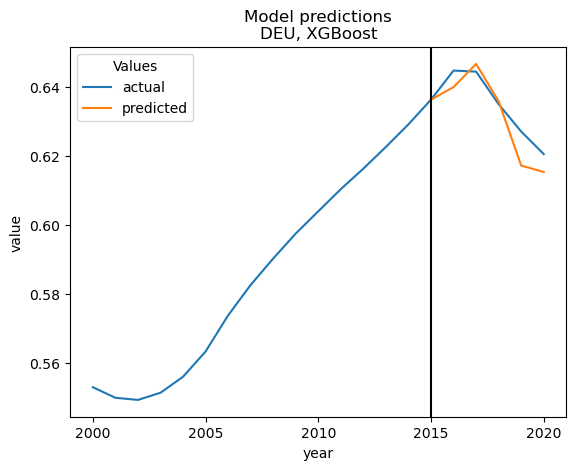

In [161]:
sns.lineplot(
    data=get_forward_pred(xgb_best, "DEU"),
    x="year",
    y="value",
    hue="Values"
)
plt.axvline(x=train["year"].max(), color="black")
plt.xticks(np.arange(2000, test["year"].max()+1, 5.0))
plt.title("Model predictions\nDEU, XGBoost")